In [17]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
import numpy as np

#import F
from torch.nn import functional as F

In [18]:
# Set device to cuda 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [19]:
image_transform = transforms.Compose([
    transforms.Resize((128,128)),transforms.ToTensor(),transforms.Lambda(lambda x : x.to(device))
])

In [20]:
from torchvision import datasets


In [23]:
trainFolder = 'train'
trainDataset = datasets.ImageFolder(trainFolder, transform=image_transform)

# Select 1000 images only to train
#trainDataset = torch.utils.data.Subset(trainDataset, np.random.choice(len(trainDataset), 1000, replace=False))

validFolder = 'val'
validDataset = datasets.ImageFolder(validFolder, transform=image_transform)

# Select 100 images only to validate
#validDataset = torch.utils.data.Subset(validDataset, np.random.choice(len(validDataset), 100, replace=False))

In [24]:
print('Train dataset:', len(trainDataset))
print('Valid dataset:', len(validDataset))

Train dataset: 4738
Valid dataset: 1500


In [67]:
#Import DataLoader
from torch.utils.data import DataLoader
batchSize = 100
trainLoader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
validLoader = DataLoader(validDataset, batch_size=batchSize, shuffle=True) 

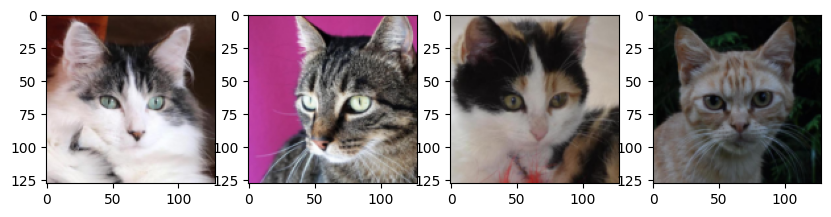

In [68]:
# print some images from the trainLoader
import matplotlib.pyplot as plt
import numpy as np
for images, labels in trainLoader:
    fig, axes = plt.subplots(figsize=(10,4), ncols=4)
    for i in range(4):
        ax = axes[i]
        ax.imshow(images[i].cpu().numpy().transpose(1,2,0).squeeze())
    break

In [69]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, in_channels: int, LatentDimension: int):
        super(VariationalAutoEncoder, self).__init__()
        self.LatentDimension = LatentDimension
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU()
        )
        
        # mean and log variance
        self.mean = nn.Linear(512*4*4, LatentDimension)
        self.logvar = nn.Linear(512*4*4, LatentDimension)
        
        # Build Decoder
        self.decoderInput = nn.Linear(LatentDimension, 512*4*4)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(in_channels=32, out_channels=in_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )
        
    def encode(self, input):
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)
        
        mean = self.mean(result)
        logVar = self.logvar(result)
        
        return [mean, logVar]
    
    def decode(self, input):
        result = self.decoderInput(input)
        result = result.view(-1, 512, 4, 4)
        result = self.decoder(result)
        return result
    

    def reparametrize(self, mean, logVar):
        std = torch.exp(0.5*logVar)
        eps = torch.randn_like(std)
        return mean + eps*std
    
    def forward(self, input):
        mean, logVar = self.encode(input)
        z = self.reparametrize(mean, logVar)
        return [self.decode(z), input, mean, logVar]
    
    def lossFunction(self, x_hat, x, mean, logVar):
        # Reconstruction loss
        reconsLoss = F.mse_loss(x_hat, x, reduction='sum')
        
        # KL Divergence Loss
        KLdivergence = torch.mean(-0.5 * torch.sum(1 + logVar - mean.pow(2) - logVar.exp(), dim=1), dim=0)
        KLDweight = 1     
        loss = reconsLoss + KLDweight * KLdivergence
        return {'loss': loss, 'Reconstruction_Loss': reconsLoss.detach(), 'KL_Divergence': KLdivergence.detach()}
    
    def sample(self, numSamples):
        z = torch.randn(numSamples, self.LatentDimension).to(device)
        return self.decode(z)
    
    def generate(self, x):
        return self.forward(x)[0]

In [70]:
# Create the model
model = VariationalAutoEncoder(in_channels=3, LatentDimension=128).to(device)

In [71]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [72]:
trainLosses = []    
validLosses = []

trainMSE = []
validMSE = []

trainKL = []
validKL = []

In [73]:
# training Loop
numEpochs = 20

for epoch in range(numEpochs):
    model.train()
    trainL = 0
    trainM = 0
    trainK = 0
    for batch_idx, (data, _) in enumerate(trainLoader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        losses = model.lossFunction(*output)
        losses["loss"].backward()
        optimizer.step()
        
        trainL += losses['loss'].item()
        trainM += losses['Reconstruction_Loss'].item()
        trainK += losses['KL_Divergence'].item()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tReconstruction Loss: {:.6f}\tKL Divergence: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainLoader.dataset),
                100. * batch_idx / len(trainLoader), losses['loss'].item(), losses['Reconstruction_Loss'].item(), losses['KL_Divergence'].item()))
    
    trainLosses.append(trainL / len(trainLoader.dataset))
    trainMSE.append(trainM / len(trainLoader.dataset))
    trainKL.append(trainK / len(trainLoader.dataset))
    
    model.eval()
    valid_loss = 0
    
    validL = 0
    validM = 0
    validK = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(validLoader):
            data = data.to(device)
            output = model(data)
            losses = model.lossFunction(*output)
            valid_loss += losses['loss'].item()
            
            
            validL += losses['loss'].item()
            validM += losses['Reconstruction_Loss'].item()
            validK += losses['KL_Divergence'].item()
            
        validLosses.append(validL / len(validLoader.dataset))
        validMSE.append(validM / len(validLoader.dataset))
        validKL.append(validK / len(validLoader.dataset))
        # plot the reconstructed images(generate one)
        for image,label in validLoader:
            image = image.to(device)
            N=6
            fig,axes=plt.subplots(2,N,figsize=(20,5))
            #plot the original images
            for i in range(N):
                axes[0,i].imshow(image[i].cpu().numpy().transpose(1,2,0).squeeze())
                axes[0,i].axis('off')
                
            #plot the reconstructed images
            recons=model.generate(image)
            for i in range(N):
                axes[1,i].imshow(recons[i].cpu().detach().numpy().transpose(1,2,0).squeeze())
                axes[1,i].axis('off')
                
            break
        #save the plot
        plt.savefig('reconstructed_images.png')
        
        # remove previous plot
        plt.clf()
        
        # sample from the model
        sample = model.sample(100)
        fig, axes = plt.subplots(10, 10, figsize=(20, 20))
        for i in range(10):
            for j in range(10):
                axes[i, j].imshow(sample[i*10+j].cpu().detach().numpy().transpose(1,2,0).squeeze())
                axes[i, j].axis('off')
                
    
            
        #save the plot
        plt.savefig('sampled_images.png')
        
        # remove previous plot
        plt.clf()
                
        valid_loss /= len(validLoader.dataset)
        print('====> Valid set loss: {:.4f}'.format(valid_loss))

Train Epoch: 0 [0/5153 (0%)]	Loss: 2663630.250000	Reconstruction Loss: 2663614.000000	KL Divergence: 16.310459


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

====> Valid set loss: 3995.6740
Train Epoch: 1 [0/5153 (0%)]	Loss: 427313.687500	Reconstruction Loss: 425527.250000	KL Divergence: 1786.423096


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

====> Valid set loss: 5429.3831
Train Epoch: 2 [0/5153 (0%)]	Loss: 199728.312500	Reconstruction Loss: 198116.343750	KL Divergence: 1611.973267


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


====> Valid set loss: 1527.1585
Train Epoch: 3 [0/5153 (0%)]	Loss: 145027.093750	Reconstruction Loss: 143667.546875	KL Divergence: 1359.539673


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


====> Valid set loss: 1321.9465
Train Epoch: 4 [0/5153 (0%)]	Loss: 134478.140625	Reconstruction Loss: 133349.375000	KL Divergence: 1128.770264


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


====> Valid set loss: 1235.2345
Train Epoch: 5 [0/5153 (0%)]	Loss: 118898.671875	Reconstruction Loss: 117899.750000	KL Divergence: 998.918701


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


====> Valid set loss: 1142.7308
Train Epoch: 6 [0/5153 (0%)]	Loss: 109533.218750	Reconstruction Loss: 108573.968750	KL Divergence: 959.253235


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


====> Valid set loss: 1129.8883
Train Epoch: 7 [0/5153 (0%)]	Loss: 106978.382812	Reconstruction Loss: 106065.812500	KL Divergence: 912.571411


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


====> Valid set loss: 1053.0455
Train Epoch: 8 [0/5153 (0%)]	Loss: 100517.554688	Reconstruction Loss: 99680.804688	KL Divergence: 836.750732
====> Valid set loss: 1004.9985
Train Epoch: 9 [0/5153 (0%)]	Loss: 93470.492188	Reconstruction Loss: 92615.609375	KL Divergence: 854.881714


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


====> Valid set loss: 976.4601
Train Epoch: 10 [0/5153 (0%)]	Loss: 87173.835938	Reconstruction Loss: 86370.609375	KL Divergence: 803.228210


/tmp/ipykernel_598032/87340348.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axes=plt.subplots(2,N,figsize=(20,5))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


====> Valid set loss: 941.1981
Train Epoch: 11 [0/5153 (0%)]	Loss: 87779.078125	Reconstruction Loss: 86984.304688	KL Divergence: 794.769531


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


====> Valid set loss: 868.2756
Train Epoch: 12 [0/5153 (0%)]	Loss: 80049.078125	Reconstruction Loss: 79256.265625	KL Divergence: 792.815613
====> Valid set loss: 879.8400
Train Epoch: 13 [0/5153 (0%)]	Loss: 83867.968750	Reconstruction Loss: 83063.328125	KL Divergence: 804.641235


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


====> Valid set loss: 848.4764
Train Epoch: 14 [0/5153 (0%)]	Loss: 72851.203125	Reconstruction Loss: 72077.335938	KL Divergence: 773.869995


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


====> Valid set loss: 832.1870
Train Epoch: 15 [0/5153 (0%)]	Loss: 73788.125000	Reconstruction Loss: 72999.546875	KL Divergence: 788.576233


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


====> Valid set loss: 832.0645
Train Epoch: 16 [0/5153 (0%)]	Loss: 76823.664062	Reconstruction Loss: 76024.546875	KL Divergence: 799.115784


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


====> Valid set loss: 805.4845
Train Epoch: 17 [0/5153 (0%)]	Loss: 71441.921875	Reconstruction Loss: 70646.851562	KL Divergence: 795.071167


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


====> Valid set loss: 805.1309
Train Epoch: 18 [0/5153 (0%)]	Loss: 69218.804688	Reconstruction Loss: 68421.296875	KL Divergence: 797.509766


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


====> Valid set loss: 799.9053
Train Epoch: 19 [0/5153 (0%)]	Loss: 70176.460938	Reconstruction Loss: 69394.679688	KL Divergence: 781.781006
====> Valid set loss: 786.3267


<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

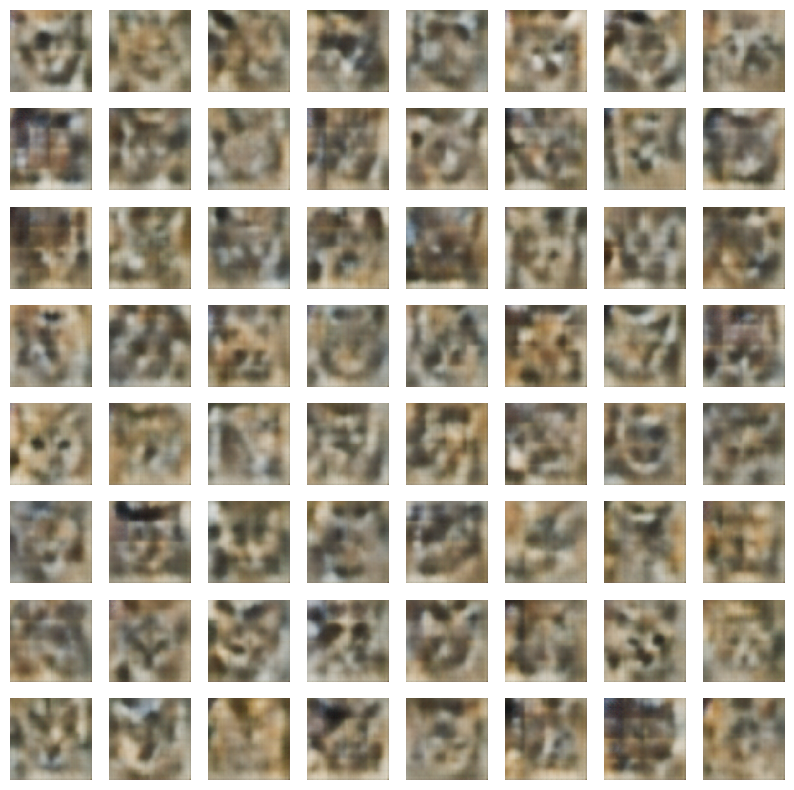

In [74]:
# sample new 64 images in 8x8 grid
N = 100
samples = model.sample(N)
fig, axes = plt.subplots(8, 8, figsize=(10, 10))
for i in range(8):
    for j in range(8):
        axes[i, j].imshow(samples[i*8+j].cpu().detach().numpy().transpose(1,2,0).squeeze())
        axes[i, j].axis('off')
plt.savefig('generated_images.png')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


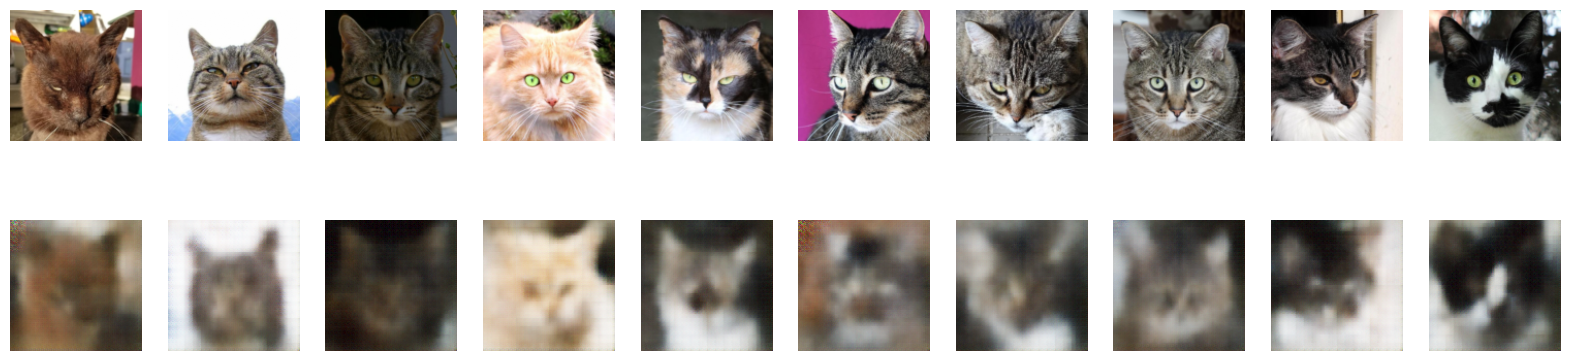

In [79]:
# Plot 100 images in validation set and their reconstructions
# in 10x10 grid

for image,label in validLoader:
    image = image.to(device)
    N=100
    
    
    fig,axes=plt.subplots(2,10,figsize=(20,5))
    #plot the original images
    for i in range(10):
        axes[0,i].imshow(image[i].cpu().numpy().transpose(1,2,0).squeeze())
        axes[0,i].axis('off')
        
    #plot the reconstructed images
    recons=model.generate(image)
    for i in range(10):
        axes[1,i].imshow(recons[i].cpu().detach().numpy().transpose(1,2,0).squeeze())
        axes[1,i].axis('off')
        
    break